<a href="https://colab.research.google.com/github/wizard339/NLP_MISIS/blob/main/final_projects/final_task_unsolved_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Финальное задание NLP-2. Рекуррентные нейронные сети

Теперь вы можете самостоятельно написать рекуррентную нейронную сеть для задачи NER, решающую задачу с достаточно высоким качеством.

В рамках этого задания вы отработаете навыки:

*   Построения словаря слов
*   Загрузки предобученных весов и использовании их для построения корпуса текста
*   Написания двунаправленной рекуррентной нейронной сети

## Установка зависимостей

Тут есть важное действие, которое тебе нужно сделать перед тем, как запускать этот ноутбук.

Если вы делаете это задание в Google Colab, первым делом переключите Runtime в GPU. Это задание нормально посчитается и на CPU, но некоторые из будущих кейсов потребуют GPU (либо вам придётся несколько часов, или даже дней, чтобы модель обучилась — и мы не преувеличиваем). Ещё мы рекомендуем переключить язык интерфейса Colab на английский, потому что русская локализация ужасна, да и вообще не нужна.

[Тут](https://www.geeksforgeeks.org/how-to-use-google-colab/) о том, как переключить рантайм.

Как обычно, установим недостающие библиотеки:

In [1]:
!pip install datasets > /dev/null
!pip install fasttext > /dev/null

In [2]:
import pytest
from datasets import load_dataset
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch import LongTensor, FloatTensor
from torch.nn import functional as F
from typing import List, Dict, Tuple, Optional, Union
from torch.utils.data import Dataset
from torch.optim import Adam
import time
from tqdm import tqdm

from collections import Counter

## Векторное представление слов

В прошлом модуле вы познакомились с представлением слова как векторов. 
В этом задании мы будем использовать веса из библиотеки Fasttext.

В качестве данных для задачи NER будем использовать уже рассмотренный нами ранее датасет conll2003, содержащий сущности 4ех разных классов — личности, организации, места и национальности.

In [3]:
dataset_base = load_dataset("conll2003")

Reusing dataset conll2003 (/root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset_base['train']

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

In [20]:
dataset_base

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

Загрузим веса модели (это может занять примерно 25 минут, веса весят 6GB).

In [5]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English

'cc.en.300.bin'

Загрузите fasttext модель cc.en.300.bin:

In [5]:
# YOUR CODE HERE
import fasttext

ft = fasttext.load_model('/content/cc.en.300.bin')

In [6]:
assert ft is not None
assert ft['Cat'].shape[0] == 300
assert ft['Cat'].sum() < -2.3 and ft['Cat'].sum() > -2.4

In [7]:
def get_word_to_idx(count: List[Tuple[str, int]],
                   min_words: Union[int, float] = 0.0,
                   max_words: Union[int, float] = 1.0) -> Dict[str, int]:
    max_count = count[0][1]
    if isinstance(min_words, float):
        min_words = max_count * min_words
    if isinstance(max_words, float):
        max_words = max_count * max_words
        
    all_words = [w[0] for w in count if max_words >= w[1] >= min_words]
    
    all_words = ['<pad>', '<unk>'] + all_words
    
    word_to_idx = {k: v for k, v in zip(all_words, range(0, len(all_words)))}
    return word_to_idx

Проинициализируйте словарь word_to_idx, убрав слова, встречающиеся больше 100 раз:

In [22]:
# YOUR CODE HERE
count = Counter([i for j in dataset_base['train'] for i in j['tokens']])
word_to_idx = get_word_to_idx(count.most_common(), max_words=100)

Посмотрим на длину словаря:

In [25]:
len(word_to_idx)

23625

In [23]:
assert isinstance(count, Counter)
assert len(word_to_idx) < 23500 
assert word_to_idx['MANCHESTER'] == 1521

Оствавим часто встречаемые слова, потому что среди них может встречаться наши прогнозируемые токены:

In [24]:
count = Counter([i for j in dataset_base['train'] for i in j['tokens']])
word_to_idx = get_word_to_idx(count.most_common(), min_words=1)

In [35]:
def build_matrix(
    word_dict: Dict,
    embedding_index,
    max_features: int = 100000,
    embed_size: int = 300,
) -> Tuple[np.array, int, List]:
    """
    Create embedding matrix

    Args:
        word_dict: tokenizer
        embedding_index: Fasttext embeddings
        max_features: max features to use
        embed_size: size of embeddings

    Returns:
        embedding matrix, number of of words and the list of not found words
    """
    embedding_index = ft
    nb_words = min(max_features, len(word_dict))
    embedding_matrix = np.zeros((nb_words, embed_size))

    for word, i in word_dict.items():
        embedding_matrix[i] = embedding_index[word]
    return embedding_matrix, nb_words

Теперь проинициализируйте матрицу embedding_matrix с использованием функции build_matrix:

In [36]:
# YOUR CODE HERE
embedding_matrix, nb_words = build_matrix(word_dict=word_to_idx, embedding_index=ft)

In [37]:
assert embedding_matrix.shape[0] == len(word_to_idx)
assert embedding_matrix[42].sum() > -1

In [38]:
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

## Реализация модели RNN

Как обычно, проверим распределение длин тренировочных текстов:

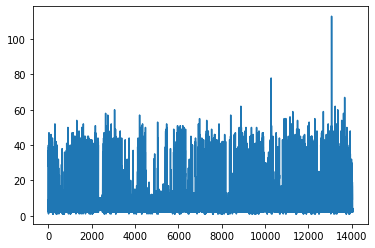

In [39]:
import pandas as pd
import numpy as np


max_lens = list()
for row in dataset_base['train']:
    max_lens.append(len(row['tokens']))
max_lens = pd.Series(max_lens)
max_lens.plot();

In [40]:
import json
mapping_ = {v: k for k, v in dataset_base["train"].features["ner_tags"].feature._str2int.items()}

with open('mapping.json', 'w') as f:
  json.dump(mapping_, f)

In [202]:
mapping_

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

Теперь заполните недостающую строчку в функции create_matrix_of_texts, так, чтобы при попадании неизвестного слова в матрице ставился индекс неизвестного слова:

In [216]:
# YOUR CODE HERE

def create_matrix_of_texts(dataset, max_sequence_length, 
                           pad_token, word2index):
    texts = np.full((len(dataset), max_sequence_length),
                    word2index[pad_token], dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row['tokens']))
          text = row['tokens'][: trim_length]
          # YOUR CODE HERE
          texts[ind, : trim_length] = [word2index[w] if w in word2index else 1 for w in text]
          # END OF YOUR CODE
    return texts


def create_matrix_of_tags(dataset, max_sequence_length, pad_index):
    tags = np.full((len(dataset), max_sequence_length),
                    pad_index, dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row['ner_tags']))
          labels = row['ner_tags'][: trim_length]
          tags[ind, : trim_length] = [item for item in labels]
    return tags

In [217]:
texts = create_matrix_of_texts(dataset_base['train'], 
                               int(max_lens.quantile(0.97)),
                               '<pad>', word_to_idx)
tags = create_matrix_of_tags(dataset_base['train'],
                             int(max_lens.quantile(0.97)), 0)

In [218]:
text_for_check = create_matrix_of_texts(dataset_base['validation'], 
                                        int(max_lens.quantile(0.97)),
                                        '<pad>', word_to_idx)
assert text_for_check[0][2] == 1
assert text_for_check[23].sum() == 40986

In [219]:
text_for_check[23]

array([21962,  3625,    30,  2530,     1,     9,  1327,   983,  6759,
         432,   496,     1,     1,    10,     3,  2814,     1,     2,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0])

Напишем класс для загрузки датасета:

In [220]:
class NerDataset(Dataset):
    def __init__(self,
                 texts: np.array,
                 tags: np.array):
        self.tags = tags
        self.texts = texts
        

    def __getitem__(self, idx: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens_tensor = torch.tensor(self.texts[idx], dtype=torch.int64)
        return tokens_tensor, torch.tensor(self.tags[idx], dtype=torch.int64)

    def __len__(self) -> int:
        dataset_len = self.texts.shape[0]
        return dataset_len

In [221]:
dataset = dataset_base['train']
ner_dataset = NerDataset(texts, tags)

In [222]:
' '.join(dataset_base['train'][0]['tokens']), ner_dataset[0]

('EU rejects German call to boycott British lamb .',
 (tensor([  958, 11984,   234,   763,     7,  4148,   210,  6183,     2,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
  tensor([3, 0, 7, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])))

Разобьем текст на тренировочную и валидационную часть:

In [223]:
from torch.utils.data.dataset import random_split

In [224]:
BATCH_SIZE = 32

In [228]:
num_train = int(len(ner_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(ner_dataset, [num_train, len(ner_dataset) - num_train])

train_dataloader = torch.utils.data.DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=False)

Наша нейронная сеть будет принимать в качестве слоя эмбеддинга предобученные веса из библиотеки fasttext, а в качестве промежуточного вычислительного звена будем использовать двунаправленную двухслойную рекуррентную сеть. Схематично ее можно изобразить как на рисунке.

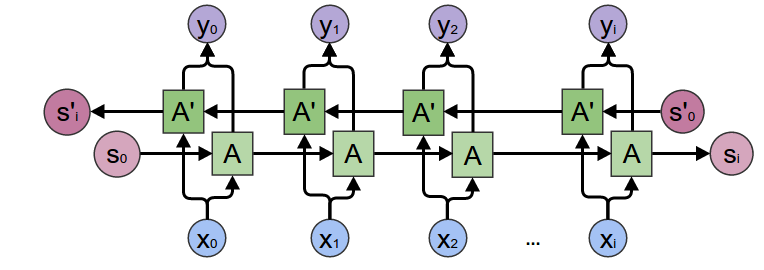

Перейдем к созданию матрицы.

Создайте класс сети RNN, у которого в слой эмбеддинга будет проинициализирован матрицей загруженных весов, а слой рекуррентной сети будет иметь параметры num_layers=1 и быть двунаправленным.
Так как мы будем использовать двунаправленный рекуррентный блок, то входная размерность выходного слоя должна быть в два раза больше чем размер скрытого состояния.  

In [341]:
class NerRNNModel(nn.Module):
    def __init__(
        self,
        pretrained_embeddings,
        mapping: Dict[int, str] = None,
        hidden_size: int = 256
    ):
        super(NerRNNModel, self).__init__()
        if not mapping:
            raise RuntimeError(f'Empty labels')

        # Vocabulary size
        self.vocab_size = pretrained_embeddings.shape[0]
        # Embedding dimensionality
        self.embedding_size = pretrained_embeddings.shape[1]
        self.labels = mapping

        # YOUR CODE HERE
        self.embedding = nn.Embedding(self.vocab_size, hidden_size)
        # END OF YOUR CODE
        self.embedding.weight = nn.Parameter(torch.tensor(pretrained_embeddings).clone().detach())
        self.embedding.requires_grad_(True)  # дообучим под свою задачу

        # YOUR CODE HERE
        self.encoder = nn.RNN(input_size=self.embedding_size, hidden_size=hidden_size, num_layers=1, bidirectional=True)
        encoder_output_value = 2*hidden_size
        # END OF YOUR CODE

        self.projection = nn.Linear(encoder_output_value, len(mapping))
        
    def forward(self, tokens: LongTensor) -> FloatTensor:
        emb = self.embedding(tokens)        
        h, _ = self.encoder(emb)
        pred = self.projection(h)
        return pred.view(-1, len(self.labels))

## Обучение модели

In [342]:
from sklearn.metrics import classification_report

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    correct_labels = [value for value in mapping_.values() if value != 'O']
    predicted, true_labels = list(), list()

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            tokens, label = batch
            tokens = tokens.to(device)
            
            logits = model(tokens)
            predictions = F.log_softmax(logits, dim=1).reshape(-1,
                                                               40,
                                                               len(mapping_)).argmax(dim=2).flatten().detach().cpu().numpy()
            predicted.extend(predictions)
            true_labels.extend(label.flatten().detach().cpu().numpy())
    
    true_labels = [mapping_[val] for val in true_labels]
    
    predicted = [mapping_[val] for val in predicted]
    print('\n', classification_report(true_labels,
                                      predicted,
                                      labels=correct_labels))

Создайте экземпляр класса сети с размером скрытого слоя равным 256.

Затем создайте оптимизатор.

Не забудьте перенести созданную модель на видеокарту для ускорения обучения!

In [343]:
# YOUR CODE HERE
EPOCHS = 7
LR = 3e-4 
BATCH_SIZE = 32


model = NerRNNModel(pretrained_embeddings=embedding_matrix, mapping=mapping_, hidden_size=256)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
device = torch.device('cuda') if torch.cuda.is_available() else  torch.device('cpu')
model.to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


NerRNNModel(
  (embedding): Embedding(23625, 256)
  (encoder): RNN(300, 256, bidirectional=True)
  (projection): Linear(in_features=512, out_features=9, bias=True)
)

In [344]:
assert sum([params.numel() for params in model.parameters() if params.requires_grad]) > 7_000_000
assert sum([params.numel() for params in model.parameters() if params.requires_grad]) < 7_500_000

In [345]:
print(sum([params.numel() for params in model.parameters() if params.requires_grad]))

7377813


Так как мы загружали уже предобученные веса, для сходимости к хорошему качеству нашей сети нужно меньше эпох, чем если бы мы обучали сеть с нуля.

In [ ]:
for e in range(10):
    total_loss = 0
    model.train()
    loss_function = nn.CrossEntropyLoss()
    for sent in tqdm(train_dataloader):

            # (1) Set gradient to zero for new example: Set gradients to zero before pass
            model.zero_grad()
            
            # (2) Encode sentence and tag sequence as sequences of indices
            input_sent, gold_tags = sent

            # (3) Predict tags (sentence by sentence)
            if len(input_sent) > 0:
                pred_scores = model(input_sent.to(device))
                mask = gold_tags != 0
                # (4) Compute loss and do backward step
                loss = loss_function(pred_scores.to(device), gold_tags.view(-1).to(device))
                loss.backward()
              
                # (5) Optimize parameter values
                optimizer.step()
          
                # (6) Accumulate loss
                total_loss += loss
    print('\nEpoch: %d, loss: %.4f' % (e, total_loss / len(train_dataloader)))
    evaluate(valid_dataloader)

 19%|█▉        | 79/416 [00:01<00:04, 79.00it/s]

Добейтесь качества обучаемой модели не ниже 0.87 по метрике weighted avg f1-score, чтобы задание считалось успешно выполненным.

# Финальное задание NLP-2. Рекуррентные нейронные сети

Теперь, когда вы изучили GRU и LSTM, вы готовы к решению задач NER с использованием подобных более продвинутых архитектур.

В рамках данного задания вы отработаете навыки:
- Работы с нетиповыми данными
- Построения словаря слов
- Написания двунаправленной рекуррентной нейронной сети на основе изученных архитектур<br>

В итоге вы напишете рекуррентную нейронную сеть для задачи NER, решающую задачу с достаточно высоким качеством.

# Загрузка данных

Загрузим данные из очень известной NLP библиотеки для работы с русским языком —  [Natasha](https://github.com/natasha/nerus).

Данные представляют из себя новости, скачанные из Lenta.ru и размеченные BIO-разметкой.

In [ ]:
!wget https://storage.yandexcloud.net/natasha-nerus/data/nerus_lenta.conllu.gz

In [ ]:
!gunzip -c nerus_lenta.conllu.gz | head

Чтобы работать с данными этой библиотеки, необходимо поставить специальный модуль.

In [ ]:
!pip install nerus

Также мы будем использовать токенизатор по пунктуации, потому что именно таким образом был размечен этот датасет.

In [ ]:
import tqdm
from nerus import load_nerus
from nltk.tokenize import WordPunctTokenizer

In [ ]:
docs = load_nerus('nerus_lenta.conllu.gz')

In [ ]:
tokenizer = WordPunctTokenizer()

Посмотрим, что из себя представляют данные:

In [ ]:
doc = next(docs)
[text.text for text in doc.sents]

In [ ]:
[' '.join([item.tag for item in text.tokens]) for text in doc.sents]

In [ ]:
train_texts, train_tags = list(), list()

for i in tqdm.tqdm(range(100000)):
  doc = next(docs)
  bad_sentences = list()
  texts = [text.text for text in doc.sents]
  tags = [' '.join([item.tag for item in text.tokens]) for text in doc.sents]

  for j in range(len(tags)):
    if set(tags[j].split()) == {'O'}:
      bad_sentences.append((texts[j], tags[j]))
  
  for s, t in bad_sentences:
    texts.remove(s)
    tags.remove(t)

  if len(tokenizer.tokenize(' '.join(texts))) == len(' '.join(tags).split()) and len(tokenizer.tokenize(' '.join(texts))) < 125:
    train_texts.append(' '.join(texts))
    train_tags.append(' '.join(tags))

## Задание 1

Проверим что данные были загружены правильно, и проинициализируем множество тегов. <br>

Создайте set всех уникальных тегов (их должно быть мало).

In [ ]:
# YOUR CODE HERE
tags = None

Проверим правильность вашего кода:

In [ ]:
from collections import Counter
assert tags is not None
assert len(tags) == 7
assert sorted(tags)[2] == 'B-PER'
assert Counter([tag for tags in train_tags for tag in tags.split()]).most_common()[1][1] < 25000

# Предобученные эмбеддинги

Мы опять будем использовать предобученные эмбеддинги, только теперь для русского языка

In [ ]:
!pip install fasttext > /dev/null

In [ ]:
import pytest
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch import LongTensor, FloatTensor
from torch.nn import functional as F
from typing import List, Dict, Tuple, Optional, Union
from torch.utils.data import Dataset
from torch.optim import Adam
import time

from collections import Counter

## Задание 2
Скачайте предобученные эмбеддинги для русского языка:

In [ ]:
# YOUR CODE HERE

In [ ]:
ft = fasttext.load_model('cc.ru.300.bin')

Мы специально выбирали новости примерно одной длины, чтобы данные были достаточно однообразны.

In [ ]:
import pandas as pd
import numpy as np


max_lens = list()
for row in train_texts:
    max_lens.append(len(tokenizer.tokenize(row)))
max_lens = pd.Series(max_lens)
max_lens.plot();
max_lens.describe()

Для проверки правильности вашего кода проинициализируйте переменную ```max_length``` 95% квантилем длинны всех строк, приведите ее к целому числу.

In [ ]:
# YOUR CODE HERE
max_lentgh = None

In [ ]:
assert len(train_texts) == 8760
assert max_length < 120
assert max_length > 100
assert isinstance(max_length, int)

In [ ]:
def get_word_to_idx(count: List[Tuple[str, int]],
                   min_words: Union[int, float] = 0.0,
                   max_words: Union[int, float] = 1.0) -> Dict[str, int]:
    max_count = count[0][1]
    if isinstance(min_words, float):
        min_words = max_count * min_words
    if isinstance(max_words, float):
        max_words = max_count * max_words
        
    all_words = [w[0] for w in count if max_words >= w[1] >= min_words]
    
    all_words = ['<pad>', '<unk>'] + all_words
    
    word_to_idx = {k: v for k, v in zip(all_words, range(0, len(all_words)))}
    return word_to_idx

In [ ]:
count = Counter([i.lower() for j in train_texts for i in tokenizer.tokenize(j)])
word_to_idx = get_word_to_idx(count.most_common(), min_words=1, max_words=100)

In [ ]:
len(word_to_idx)

In [ ]:
tag_to_idx = {v: k for k, v in enumerate(set([tag for tags in train_tags for tag in list(set(tags.split()))]))}
tag_to_idx

## Задание 3
Напишите функцию по построению матрицы, использующую прдобученные эмбеддинги.

In [ ]:
# YOUR CODE HERE
def build_matrix(
    word_dict: Dict,
    embedding_index,
    max_features: int = 100000,
    embed_size: int = 100,
) -> Tuple[np.array, int, List]:
  pass

In [ ]:
embedding_matrix, nb_words = build_matrix(word_dict=word_to_idx,
                                          embedding_index=ft,
                                          embed_size=300)

Проверим, корректно ли работает функция:

In [ ]:
assert embedding_matrix.shape[0] < 75000
assert nb_words > 8 ** 3
assert embedding_matrix[42].sum(axis=0) > -2

In [ ]:
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

## Задание 4
Напишите функцию по созданию матрицы текстов и матрицы тегов. Не забудьте, что нужно использовать токенизацию при разбиении текстов новостей.

In [ ]:
# YOUR CODE HERE

def create_matrix_of_texts(dataset, max_sequence_length, 
                           pad_token, word2index):
    texts = np.full((len(dataset), max_sequence_length),
                    word2index[pad_token], dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(tokenizer.tokenize(row.lower())))
          text = # ADD CODE HERE
          texts[ind, : trim_length] = # ADD CODE HERE
    return texts


def create_matrix_of_tags(dataset, max_sequence_length, pad_index, tag2index):
    tags = np.full((len(dataset), max_sequence_length),
                    pad_index, dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row.split()))
          labels = # ADD CODE HERE
          tags[ind, : trim_length] = # ADD CODE HERE
    return tags

In [ ]:
texts_matrix = create_matrix_of_texts(train_texts, 
                               max_length,
                               '<pad>', word_to_idx)
tags_matrix = create_matrix_of_tags(train_tags,
                             max_length, tag_to_idx['O'], tag_to_idx)

In [ ]:
assert tags_matrix[6].sum() == 23
assert texts_matrix[2029].mean() > 4500
assert texts_matrix.shape[1] == max_length

# Загрузка датасета

Объединим матрицы текстов и матрицы тегов в обучающий датасет, используя знакомый вам класс загрузки датасетов.

In [ ]:
class NerDataset(Dataset):
    def __init__(self,
                 texts: np.array,
                 tags: np.array):
        self.tags = tags
        self.texts = texts
        

    def __getitem__(self, idx: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens_tensor = torch.tensor(self.texts[idx], dtype=torch.int64)
        return tokens_tensor, torch.tensor(self.tags[idx], dtype=torch.int64)

    def __len__(self) -> int:
        dataset_len = self.texts.shape[0]
        return dataset_len

In [ ]:
dataset = train_tags
ner_dataset = NerDataset(texts_matrix, tags_matrix)

In [ ]:
idx_to_tag = {second: first for first, second in tag_to_idx.items()}

In [ ]:
from torch.utils.data.dataset import random_split

In [ ]:
BATCH_SIZE = 64

In [ ]:
num_train = int(len(ner_dataset) * 0.9)
split_train_, split_valid_ = \
    random_split(ner_dataset, [num_train, len(ner_dataset) - num_train])

train_dataloader = torch.utils.data.DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True)

# Обучение модели

## Задание 5
Создайте свою нейронную сеть. Попробуйте разные вариации архитектур RNN, посмотрите, что дает размораживание или заморозка предобученных весов.

В дальнейшем вы выберите ту модель, которая демонстрирует лучшее качество.

In [ ]:
# INSERT YOUR CODE

class NerRNNModel(nn.Module):
    def __init__(
        self,
        pretrained_embeddings,
        mapping: Dict[int, str] = None,
        hidden_size: int = 256
    ):
        super(NerRNNModel, self).__init__()
        if not mapping:
            raise RuntimeError(f'Empty labels')

        # Vocabulary size
        self.vocab_size = pretrained_embeddings.shape[0]
        # Embedding dimensionality
        self.embedding_size = pretrained_embeddings.shape[1]
        self.labels = mapping
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.embedding.requires_grad_(True)
        self.encoder = # ADD YOUR CODE HERE

        encoder_output_value = # ADD YOUR CODE HERE

        self.projection = nn.Linear(encoder_output_value, len(mapping))
        
    def forward(self, tokens: LongTensor) -> FloatTensor:
        emb = self.embedding(tokens)        
        h, _ = # ADD YOUR CODE HERE
        pred = # ADD YOUR CODE HERE
        return pred.view(-1, len(self.labels))

In [ ]:
idx_to_word = {second: first for first, second in word_to_idx.items()}

In [ ]:
from sklearn.metrics import classification_report

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    correct_labels = [value for value in idx_to_tag.values() if value != 'O']
    predicted, true_labels = list(), list()

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            tokens, label = batch
            tokens = tokens.to(device)
            
            logits = model(tokens)
            predictions = F.log_softmax(logits, dim=1).reshape(-1,
                                                               max_length,
                                                               len(idx_to_tag)).argmax(dim=2).flatten().detach().cpu().numpy()
            predicted.extend(predictions)
            true_labels.extend(label.flatten().detach().cpu().numpy())
    
    true_labels = [idx_to_tag[val] for val in true_labels]
    
    predicted = [idx_to_tag[val] for val in predicted]
    print('\n', classification_report(true_labels,
                                      predicted,
                                      labels=correct_labels))

In [ ]:
model = NerRNNModel(embedding_matrix, tag_to_idx, 256)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [ ]:
sum([params.numel() for params in model.parameters() if params.requires_grad])

## Задание 6
Дополните цикл обучения:

In [ ]:
# INSERT YOUR CODE

for e in range(8):
    total_loss = 0
    model.train()
    loss_function = nn.CrossEntropyLoss()
    for sent in tqdm.auto.tqdm(train_dataloader):

            # (1) Set gradient to zero for new example: Set gradients to zero before pass
            model... # ADD YOUR CODE inplace ...
            
            # (2) Encode sentence and tag sequence as sequences of indices
            input_sent, gold_tags = sent

            # (3) Predict tags (sentence by sentence)
            if len(input_sent) > 0:
                pred_scores = model(input_sent.to(device))
                mask = gold_tags != tag_to_idx['O']
                # (4) Compute loss and do backward step
                loss = # ADD YOUR CODE
              
                # (5) Optimize parameter values
                optimizer... # ADD YOUR CODE inplace ...
          
                # (6) Accumulate loss
                total_loss += loss
    print('\nEpoch: %d, loss: %.4f' % (e, total_loss / len(train_dataloader)))
    evaluate(valid_dataloader)

Попробуйте различные подходы, добейтесь качества модели больше 0.5 по micro avg f1-score. <br>

### Подсказка

Иногда простые модели бьют куда более сложные нейронные сети :)